In [1]:
import tensorflow as tf
import glob
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from tensorflow.keras import layers, Model

2025-07-03 16:00:09.272967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751558409.288097    2302 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751558409.292700    2302 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751558409.305228    2302 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751558409.305244    2302 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751558409.305246    2302 computation_placer.cc:177] computation placer alr

Read TensorFlow Records

In [2]:
# --- Code to Calculate Total Dataset Size ---

# 1. Find all your TFRecord files using a glob pattern.
DATA_FOLDER = 'tfrecords/'
FILE_PATTERN = os.path.join(DATA_FOLDER, 'colombia_production_data-*.tfrecord.gz')
tfrecord_files = glob.glob(FILE_PATTERN)

if not tfrecord_files:
    raise FileNotFoundError(f"No TFRecord files found matching pattern: {FILE_PATTERN}")

print(f"Found {len(tfrecord_files)} TFRecord files.")

# 2. Create a dataset object from ALL files.
#    We only need to read the raw records, we don't need to parse them yet.
raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type='GZIP')

# 3. Iterate and count.
#    This is the most direct way to count. It will read through the files
#    but doesn't do the expensive parsing or decoding work.
print("Counting total number of patches... (This may take a minute)")
start_time = time.time()

# Using a simple loop
# total_patches = 0
# for _ in raw_dataset:
#     total_patches += 1

# A more "TensorFlow-onic" and potentially faster way using reduce:
total_patches = raw_dataset.reduce(0, lambda x, _: x + 1).numpy()


end_time = time.time()

print("\n==============================================")
print("      TRAINING DATASET SIZE REPORT")
print("==============================================")
print(f"Total number of 256x256 patches: {total_patches:,}")
print(f"Calculation time: {end_time - start_time:.2f} seconds")

# 4. Calculate other metrics
PATCH_SIZE = 256
PIXELS_PER_PATCH = PATCH_SIZE * PATCH_SIZE
TOTAL_PIXELS = total_patches * PIXELS_PER_PATCH

# Sentinel-2 resolution is 10 meters/pixel
METERS_PER_PIXEL_SIDE = 10
SQ_METERS_PER_PIXEL = METERS_PER_PIXEL_SIDE ** 2
SQ_KM_PER_PIXEL = SQ_METERS_PER_PIXEL / 1_000_000

TOTAL_AREA_SQ_KM = TOTAL_PIXELS * SQ_KM_PER_PIXEL

print(f"Found {len(tfrecord_files)} TFRecord files.")
print(f"Total number of pixels: {TOTAL_PIXELS:,}")
print(f"Total unique area covered: {TOTAL_AREA_SQ_KM:,.2f} km²")
print("==============================================\n")

Found 3 TFRecord files.
Counting total number of patches... (This may take a minute)


2025-07-03 16:00:11.893053: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-07-03 16:00:11.975236: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144



      TRAINING DATASET SIZE REPORT
Total number of 256x256 patches: 953
Calculation time: 6.70 seconds
Found 3 TFRecord files.
Total number of pixels: 62,455,808
Total unique area covered: 6,245.58 km²



Found and processing file: tfrecords/colombia_production_data-00005.tfrecord.gz
Will visualize 5 random samples.

SUCCESS! Parsed 5 records for visualization.
Generating visualizations...


2025-07-03 16:00:19.424087: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


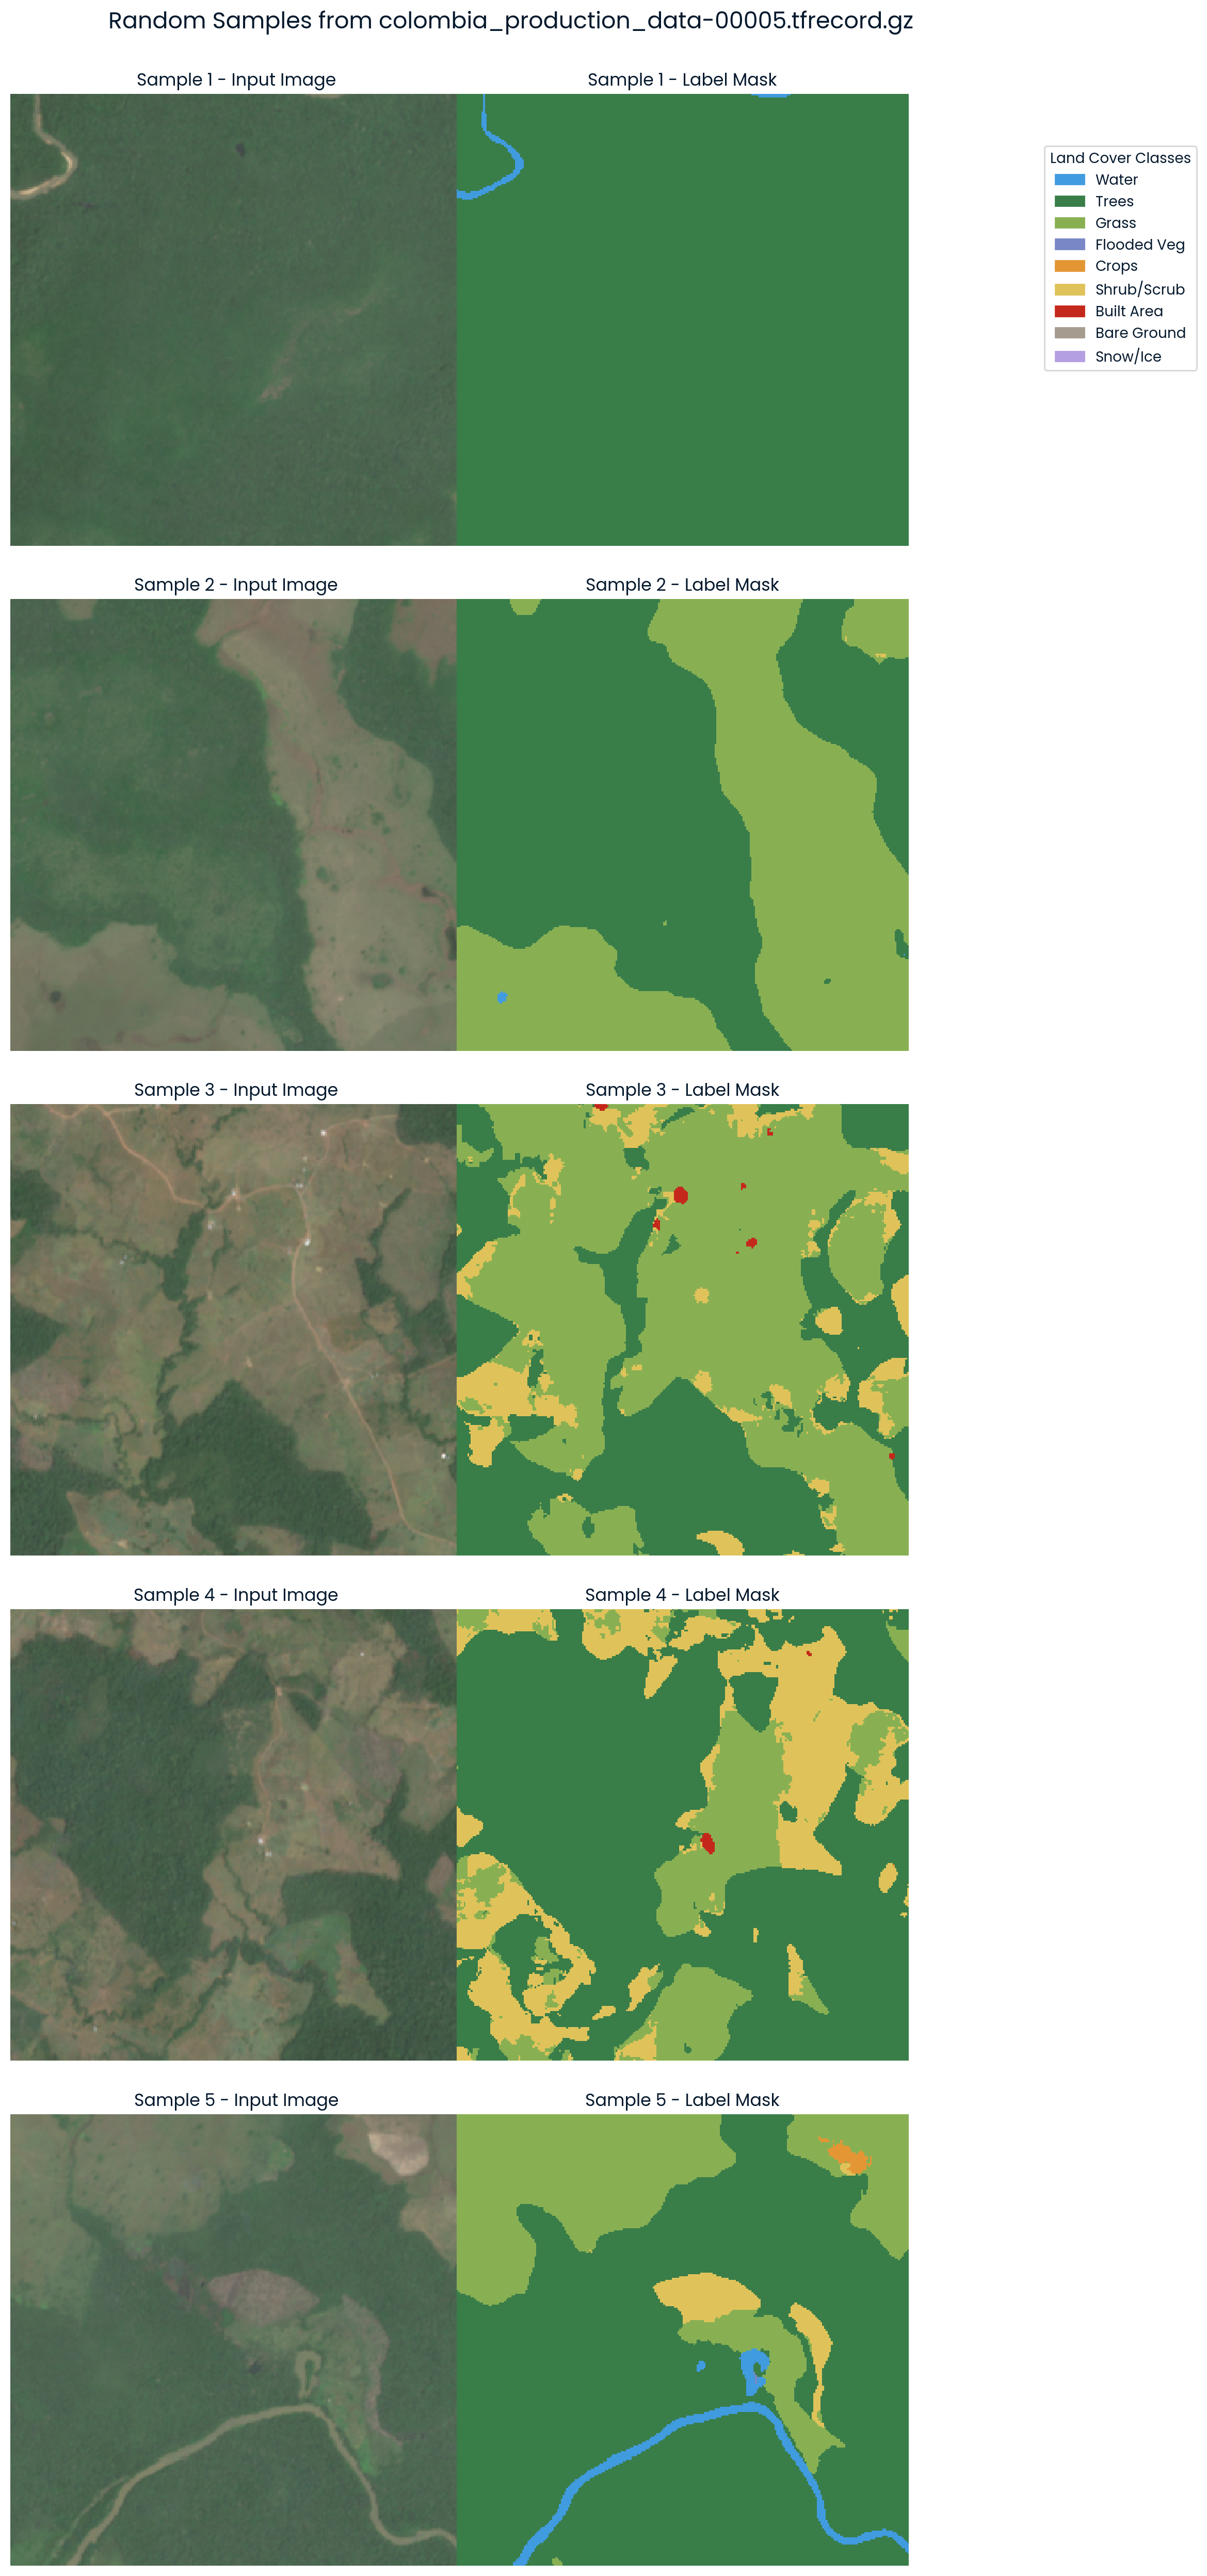

In [3]:
# =============================================================================
# 1. Configuration - Point this to one of your valid files
# =============================================================================
# Select one of your TFRecord files to visualize samples from.
FILE_NAME = 'colombia_production_data-00005.tfrecord.gz'
DATA_DIR = 'tfrecords'
FILE_PATH = os.path.join(DATA_DIR, FILE_NAME)
NUM_SAMPLES_TO_VISUALIZE = 5

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}")

print(f"Found and processing file: {FILE_PATH}")
print(f"Will visualize {NUM_SAMPLES_TO_VISUALIZE} random samples.")

# =============================================================================
# 2. The Proven, Working Parser
# =============================================================================
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']
LABEL_BAND = 'label'
PATCH_SIZE = 256
NUM_CLASSES = 9

# --- Dynamic World Information ---
CLASS_NAMES = [
    'Water', 'Trees', 'Grass', 'Flooded Veg', 'Crops',
    'Shrub/Scrub', 'Built Area', 'Bare Ground', 'Snow/Ice'
]
VIS_PALETTE = [
    '#419bdf', '#397d49', '#88b053', '#7a87c6', '#e49635',
    '#dfc35a', '#c4281b', '#a59b8f', '#b39fe1'
]

def parse_real_tfrecord(example_proto):
    # (Parser code is unchanged)
    feature_description = {}
    for band in BANDS:
        feature_description[band] = tf.io.FixedLenFeature([PATCH_SIZE, PATCH_SIZE], tf.float32)
    feature_description[LABEL_BAND] = tf.io.FixedLenFeature([], tf.string)
    example = tf.io.parse_single_example(example_proto, feature_description)
    label_decoded = tf.io.decode_raw(example[LABEL_BAND], tf.uint8)
    label = tf.reshape(label_decoded, [PATCH_SIZE, PATCH_SIZE])
    image = tf.stack([example[band] for band in BANDS], axis=-1)
    return image, label

# =============================================================================
# 3. Read and Parse Multiple Records
# =============================================================================
dataset = tf.data.TFRecordDataset(FILE_PATH, compression_type='GZIP')
# Shuffle the dataset to get random samples, not just the first 5.
# A buffer size of ~100 is plenty for visualization purposes.
shuffled_dataset = dataset.shuffle(buffer_size=100)
parsed_dataset = shuffled_dataset.map(parse_real_tfrecord)

# *** KEY CHANGE HERE ***
# Use .take(N) to grab N samples from the dataset.
# .as_numpy_iterator() is a convenient way to loop through them.
dataset_iterator = parsed_dataset.take(NUM_SAMPLES_TO_VISUALIZE).as_numpy_iterator()

print(f"\nSUCCESS! Parsed {NUM_SAMPLES_TO_VISUALIZE} records for visualization.")

# =============================================================================
# 4. Visualize the Data in a Grid
# =============================================================================
print("Generating visualizations...")

# --- Create the Custom Colormap and Normalization (do this once) ---
dw_colormap = ListedColormap(VIS_PALETTE)
bounds = np.arange(-0.5, NUM_CLASSES, 1)
dw_norm = BoundaryNorm(bounds, dw_colormap.N)

# --- Create a figure with multiple rows ---
# We'll have N rows, 2 columns (one for image, one for label)
fig, axes = plt.subplots(NUM_SAMPLES_TO_VISUALIZE, 2, figsize=(10, 5 * NUM_SAMPLES_TO_VISUALIZE))
fig.suptitle(f'Random Samples from {FILE_NAME}', fontsize=16, y=1.0)


# --- Loop through the iterator and plot each sample ---
for i, (image_numpy, label_numpy) in enumerate(dataset_iterator):
    
    # --- Process the image for visualization ---
    # Create a True-Color Image (TCI)
    red_channel   = image_numpy[..., 2] # Index 2 for B4 (Red)
    green_channel = image_numpy[..., 1] # Index 1 for B3 (Green)
    blue_channel  = image_numpy[..., 0] # Index 0 for B2 (Blue)
    
    tci_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)
    # Apply gamma correction for better visual appeal
    tci_image = np.clip(tci_image, 0, 1) ** (1 / 1.8)

    # --- Plot the True-Color Image on the left subplot for this row ---
    ax = axes[i, 0]
    ax.imshow(tci_image)
    ax.set_title(f'Sample {i+1} - Input Image')
    ax.axis('off')

    # --- Plot the Label Mask on the right subplot for this row ---
    ax = axes[i, 1]
    im = ax.imshow(label_numpy, cmap=dw_colormap, norm=dw_norm)
    ax.set_title(f'Sample {i+1} - Label Mask')
    ax.axis('off')

# --- Create a single, shared legend for the entire figure ---
patches = [Patch(color=VIS_PALETTE[i], label=CLASS_NAMES[i]) for i in range(NUM_CLASSES)]
fig.legend(handles=patches, bbox_to_anchor=(1.01, 0.95), loc='upper left', title="Land Cover Classes")

plt.tight_layout(rect=[0, 0, 0.9, 1.0]) # Adjust layout to make room for the legend
plt.show()

# Modelling

In [4]:
# --- 1. Define Constants ---
# These must match what you used during export!
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']
LABEL_BAND = 'label'
ALL_BANDS = BANDS + [LABEL_BAND]
PATCH_SIZE = 256
# BATCH_SIZE = 32 # Adjust based on your GPU memory
BATCH_SIZE = 16 # Adjusted for Datalab environment
BUFFER_SIZE = 2000 # For shuffling
NUM_CLASSES = 9 # Number of Dynamic World classes
NUM_BANDS = len(BANDS)

In [5]:
# --- Parsing Function ---
def parse_tfrecord(example_proto):
    # 1. Define the feature description with the 2D shape for the feature bands.
    feature_description = {}
    
    # *** THIS IS THE LIKELY FIX ***
    # For the feature bands, expect them as a 2D tensor.
    for band in BANDS:
        feature_description[band] = tf.io.FixedLenFeature([PATCH_SIZE, PATCH_SIZE], tf.float32)
    
    # For the label band, we know it's a byte string from the previous error.
    feature_description[LABEL_BAND] = tf.io.FixedLenFeature([], tf.string)

    # 2. Parse the input `tf.train.Example` proto.
    example = tf.io.parse_single_example(example_proto, feature_description)

    # 3. Handle the label band: Decode and Reshape.
    label_decoded = tf.io.decode_raw(example[LABEL_BAND], tf.uint8)
    label_reshaped = tf.reshape(label_decoded, [PATCH_SIZE, PATCH_SIZE])

    # 4. Handle the feature bands: No reshaping needed anymore!
    # The tensor is already a [256, 256] float tensor.
    features_list = [example[band] for band in BANDS]
    
    # 5. Stack the feature bands into a single tensor (the image).
    image_stack = tf.stack(features_list, axis=-1)
    
    # 6. One-hot encode the label.
    label_int = tf.cast(label_reshaped, tf.int32)
    label_one_hot = tf.one_hot(label_int, depth=NUM_CLASSES)
    
    return image_stack, label_one_hot

In [6]:
# --- 5. Build the Full Pipeline ---
# Map the parsing function across the dataset.
parsed_dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

# Apply standard transformations.
# AUTOTUNE - TensorFlow figures out the best parallelization.
train_dataset = (
    parsed_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Pre-fetches the next batch while the current one is processing
)

print("Data pipeline built successfully.")

Data pipeline built successfully.


In [7]:
def build_unet_model(input_shape=(PATCH_SIZE, PATCH_SIZE, NUM_BANDS), num_classes=NUM_CLASSES):
    """
    Builds a U-Net model with correct skip connections.
    """
    inputs = layers.Input(shape=input_shape)

    # --- Encoder Path (Contracting Path) ---
    # Captures context. Each block halves the spatial dimensions (H, W) and doubles the channels.

    # Block 1: 256x256 -> 128x128
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1) # Shape: (None, 128, 128, 32)

    # Block 2: 128x128 -> 64x64
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2) # Shape: (None, 64, 64, 64)

    # Block 3: 64x64 -> 32x32
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3) # Shape: (None, 32, 32, 128)

    # --- Bottleneck ---
    # The lowest resolution, highest-level feature representation.
    b = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    b = layers.Dropout(0.3)(b)
    b = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b)
    # Shape of b: (None, 32, 32, 256)

    # --- Decoder Path (Expansive Path) ---
    # Reconstructs the image, enabling precise localization. Each block doubles the spatial dimensions.

    # Block 6: 32x32 -> 64x64
    # Upsample the bottleneck features
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b) # Shape: (None, 64, 64, 128)
    # Concatenate with the skip connection from the corresponding encoder block (c3)
    # c3 shape is (None, 32, 32, 128) -- wait, this is wrong. Let's fix.
    # The skip connection for upsampling from 32x32 should be the output of block 3, which is c3.
    # Let's trace back: p3 is 32x32, b is 32x32. u6 upsamples b to 64x64.
    # The corresponding encoder feature map is c2, which is 64x64. Let's correct the connections.
    
    # Correct Decoder Path:

    # Block 1 (Decoder): Upsample bottleneck from 32x32 to 64x64
    u1_dec = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b) # Now 64x64x128
    # Concatenate with the skip connection from encoder block 3 (c3)
    # NO, c3 is 32x32. We need to concatenate with c2 (64x64). Let's restart the decoder logic clearly.
    
    # --- PROPER Decoder Path ---

    # Upsampling Block 1: From 32x32 (bottleneck) to 64x64
    u3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b) # Shape -> (None, 64, 64, 128)
    # Now concatenate with c3 from the encoder path, which is also 64x64. Let's re-verify c3 shape.
    # Ah, I see the confusion in the trace. Let's trace shapes carefully.
    # c1: 256x256, p1: 128x128
    # c2: 128x128, p2: 64x64
    # c3: 64x64,   p3: 32x32
    # b:  32x32
    
    # So, to upsample from b (32x32), we must concatenate with c3 (64x64). This is the error!
    # Let's upsample b (32x32) -> u3 (64x64). We should concatenate with c3, which is 64x64.
    
    # My previous trace was wrong. Let's restart the shape trace properly.
    #
    # ENCODER
    # c1 (256x256x32) -> p1 (128x128x32)
    # c2 (128x128x64) -> p2 (64x64x64)
    # c3 (64x64x128)  -> p3 (32x32x128)
    #
    # BOTTLENECK
    # b  (32x32x256)
    #
    # DECODER
    # u6 (upsample b) -> (64x64x128)
    # We must concatenate u6 with c3 (64x64x128). Their shapes match.
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u6 = layers.concatenate([u6, c3]) # Concatenate on the channel axis
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    # Upsampling Block 2: From 64x64 to 128x128
    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6) # -> (128x128x64)
    # Concatenate with c2 from the encoder path (128x128x64)
    u7 = layers.concatenate([u7, c2])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.1)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Upsampling Block 3: From 128x128 to 256x256
    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7) # -> (256x256x32)
    # Concatenate with c1 from the encoder path (256x256x32)
    u8 = layers.concatenate([u8, c1])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # --- Output Layer ---
    # Use a 1x1 convolution to map the final feature channels to the number of classes.
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# --- Instantiate and Compile the Model ---
# This model will now compile without errors.
model = build_unet_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=list(range(NUM_CLASSES)))])

# Print the summary to verify the architecture and parameter count.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      2,624 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_3[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 64, 64,    │    131,200 │ conv2d_7[0][0]  

 Total params: 1,927,593 (7.35 MB)

 Trainable params: 1,927,593 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step 5 - Train the model
# Optional: Split your dataset into training and validation sets
# A 90/10 split is common.
DATASET_SIZE = len(list(parsed_dataset)) # This can be slow for huge datasets
train_size = int(0.9 * DATASET_SIZE)
val_size = DATASET_SIZE - train_size

full_dataset = parsed_dataset.shuffle(BUFFER_SIZE)
train_split = full_dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_split = full_dataset.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Define callbacks, e.g., to save the best model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

# Train the model
EPOCHS = 50
history = model.fit(
    train_split,
    epochs=EPOCHS,
    validation_data=val_split,
    callbacks=callbacks
)

Epoch 1/50


2025-07-03 16:00:21.976391: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


      4/Unknown 22s 4s/step - accuracy: 0.4611 - loss: 1.8041 - one_hot_io_u: 0.0685

2025-07-03 16:00:44.951493: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.4646 - loss: 1.7704 - one_hot_io_u: 0.0701 - val_accuracy: 0.5841 - val_loss: 1.0955 - val_one_hot_io_u: 0.1096
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.5717 - loss: 1.0190 - one_hot_io_u: 0.0911 - val_accuracy: 0.7575 - val_loss: 0.8096 - val_one_hot_io_u: 0.1759
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6815 - loss: 0.8583 - one_hot_io_u: 0.1341

2025-07-03 16:01:23.571140: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.6862 - loss: 0.8532 - one_hot_io_u: 0.1358 - val_accuracy: 0.9122 - val_loss: 0.4490 - val_one_hot_io_u: 0.2146
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8247 - loss: 0.6467 - one_hot_io_u: 0.1844 - val_accuracy: 0.9303 - val_loss: 0.2784 - val_one_hot_io_u: 0.2167
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8590 - loss: 0.4988 - one_hot_io_u: 0.1974 - val_accuracy: 0.7853 - val_loss: 0.6708 - val_one_hot_io_u: 0.1990
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8388 - loss: 0.5255 - one_hot_io_u: 0.1898 - val_accuracy: 0.8956 - val_loss: 0.3521 - val_one_hot_io_u: 0.2383
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8480 - loss: 0.4753 - one_hot_io_u: 0.1991 - val_accuracy: 0.8378 - val_loss: 0.5190 - val_one_hot_io_u: 0.1918
Epoch 8/50


2025-07-03 16:02:39.864631: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8532 - loss: 0.4533 - one_hot_io_u: 0.1963 - val_accuracy: 0.9047 - val_loss: 0.3131 - val_one_hot_io_u: 0.2135
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8658 - loss: 0.4207 - one_hot_io_u: 0.2006 - val_accuracy: 0.9390 - val_loss: 0.2186 - val_one_hot_io_u: 0.2239
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8770 - loss: 0.3774 - one_hot_io_u: 0.2032 - val_accuracy: 0.7687 - val_loss: 0.6809 - val_one_hot_io_u: 0.1931
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8673 - loss: 0.4042 - one_hot_io_u: 0.2026 - val_accuracy: 0.8176 - val_loss: 0.5037 - val_one_hot_io_u: 0.2099
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8729 - loss: 0.3803 - one_hot_io_u: 0.2045 - val_accuracy: 0.8896 - val_loss: 0.3428 - val_one_hot_io_u: 0.2167
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8606 - loss: 0.4149 - one_hot_io_u: 0.2515 - val_accuracy: 0.8700 - val_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


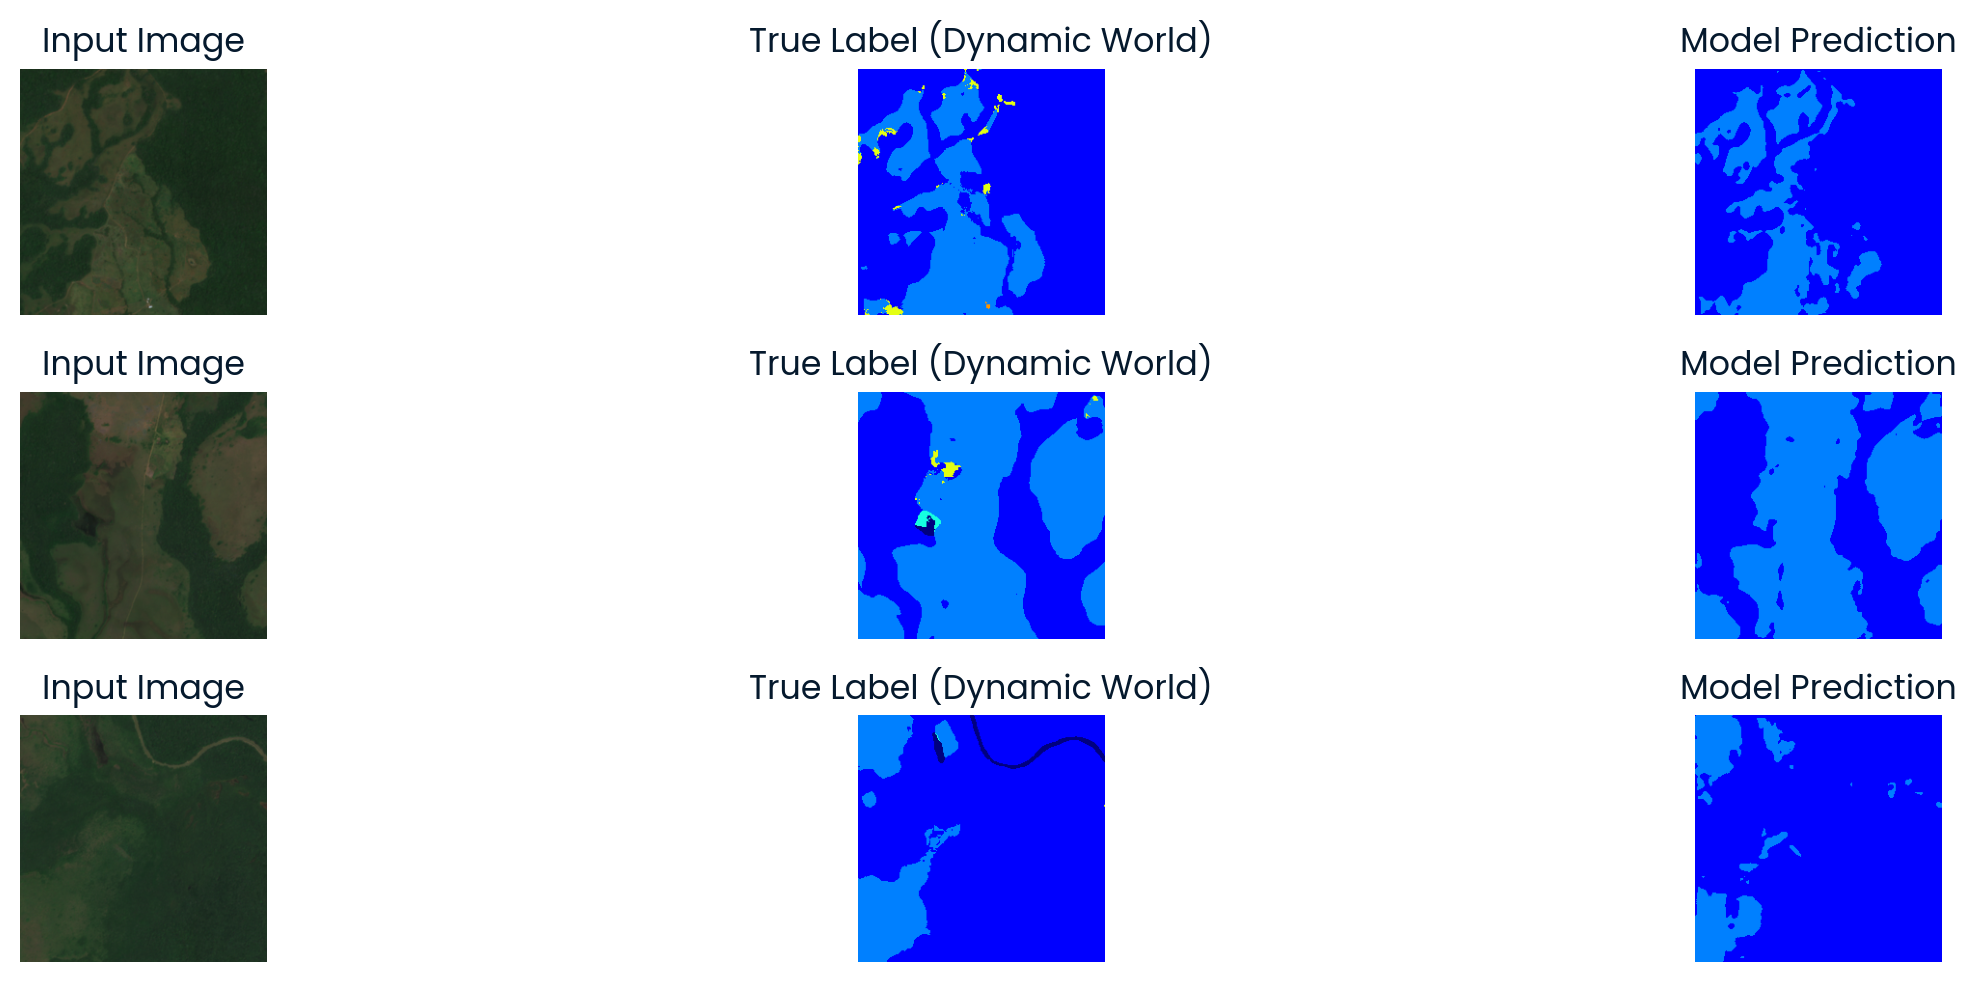

In [9]:
# Step 6: Evaluate and Visualize Predictions
import matplotlib.pyplot as plt
import numpy as np

# Load the best saved model
trained_model = tf.keras.models.load_model('best_model.keras')

# Grab a single batch from the validation set
for image_batch, label_batch in val_split.take(1):
    # Make predictions
    prediction_batch = trained_model.predict(image_batch)
    
    # Get the class with the highest probability for each pixel
    predicted_labels = np.argmax(prediction_batch, axis=-1)
    true_labels = np.argmax(label_batch, axis=-1)
    
    # Visualize a few examples
    plt.figure(figsize=(15, 5))
    for i in range(3):
        # Plot the input image (using true-color bands)
        plt.subplot(3, 3, i*3 + 1)
        # S2 bands are B2, B3, B4. We need to find their indices.
        # B4 (Red) is index 2, B3 (Green) is 1, B2 (Blue) is 0.
        rgb_image = image_batch.numpy()[i][..., [2, 1, 0]]
        plt.imshow(rgb_image)
        plt.title("Input Image")
        plt.axis('off')
        
        # Plot the true labels
        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(true_labels[i], cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
        plt.title("True Label (Dynamic World)")
        plt.axis('off')

        # Plot the predicted labels
        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(predicted_labels[i], cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
        plt.title("Model Prediction")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break